# 時系列分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("weather.csv", index_col='年月', encoding="shift-jis", parse_dates=True)

In [3]:
df.head(5)

,平均気温,品質情報,均質番号
年月,,,
2000-01-01,7.6,8,1
2000-02-01,6.0,8,1
2000-03-01,9.4,8,1
2000-04-01,14.5,8,1
2000-05-01,19.8,8,1


In [4]:
# グラフを大きくして見やすくします。
plt.rcParams['figure.figsize'] = 20, 5

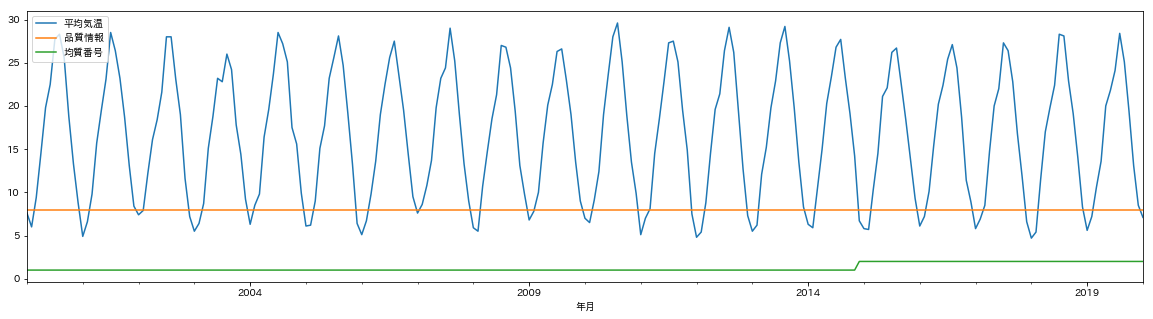

In [5]:
df.plot().legend(loc='upper left')

In [6]:
ts = df['平均気温']

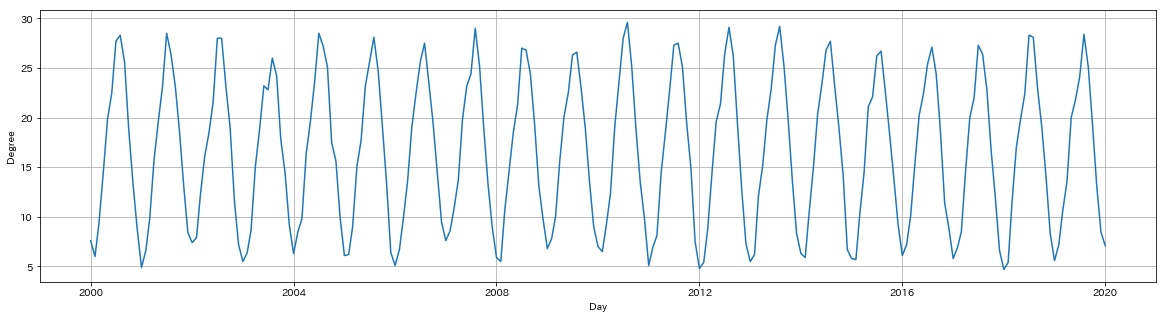

In [7]:
plt.plot(ts)
plt.ylabel('Degree')
plt.xlabel('Day')
plt.grid()
plt.show()

In [8]:
# タイプ、shape確認
print(ts.dtype, ts.shape)

float64 (241,)


In [9]:
ts_log = np.log(ts + 1e-8) # log(0)にならないようにごく小さな値を加える

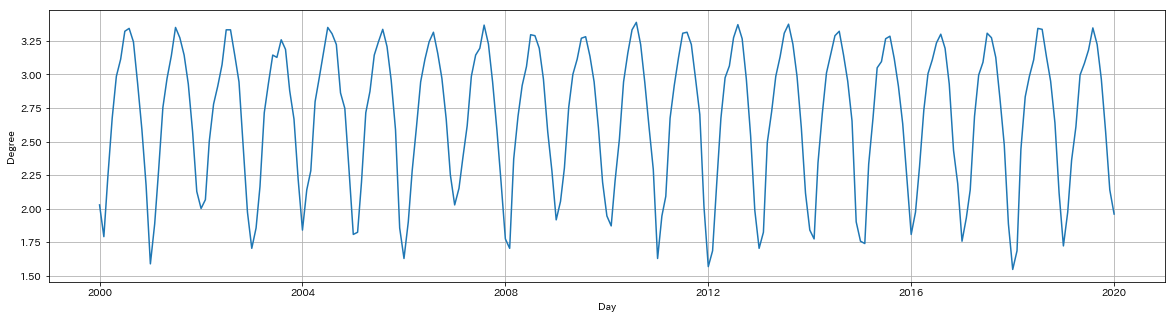

In [10]:
# 対数変換してもグラフの形は同じように残るため、心配無用
plt.plot(ts_log)
plt.ylabel('Degree')
plt.xlabel('Day')
plt.grid()
plt.show()

In [11]:
ts_diff = []
for i in range(len(ts)-1):
    j = i+1
    ts_diff.append(ts[j] - ts[j-1]) # numpy.appendは遅くなりがちなので配列で計算
ts_diff = np.array(ts_diff)

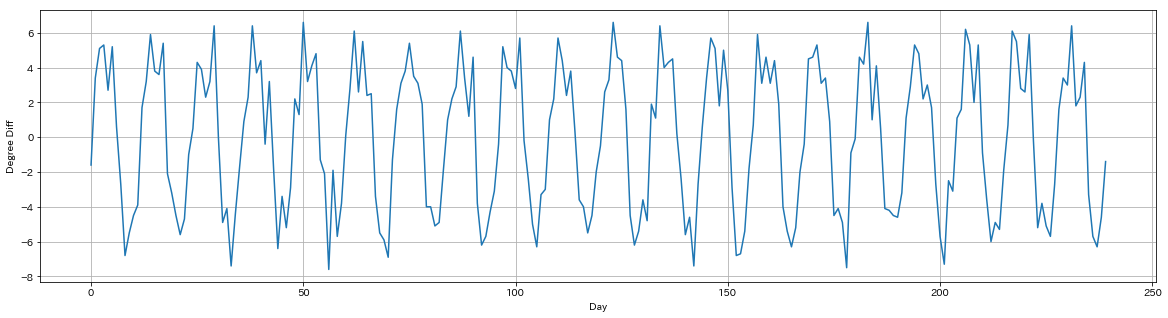

In [12]:
plt.plot(ts_diff)
plt.ylabel('Degree Diff')
plt.xlabel('Day')
plt.grid()
plt.show()

In [13]:
import statsmodels.api as sm

In [14]:
acv_len = 24

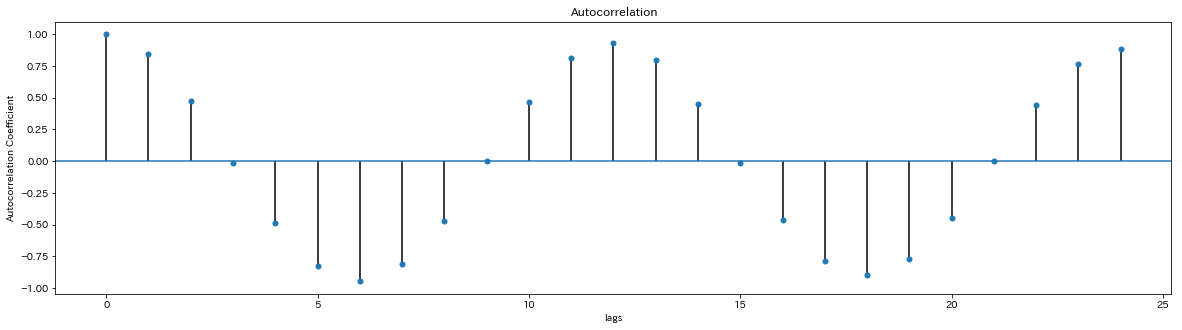

In [15]:
sm.graphics.tsa.plot_acf(ts, lags=acv_len, alpha = None)
plt.xlabel("lags")
plt.ylabel("Autocorrelation Coefficient")
plt.show()

In [16]:
acv_all = []
for lags in range(acv_len): # ラグ（比較する差の大きさ）
    n = len(ts) # 全体のデータ数：n
    n_lag = n - lags # ラグ時のデータ数：n - lags
    ut = np.mean(ts) # 平均値µの導出：ut
    # Σ計算用配列
    acv_up = []
    acv_dw = []
    # 上部式計算 1/n_lag*Σ((yt1 - ut) * (yt2 - ut))
    for i in range(n_lag):
        yt1 = ts[i]
        yt2 = ts[i+lags]
        acv_up.append((yt1 - ut) * (yt2 - ut))
    # 下部計算 1/n*Σ((yt - ut)^2)
    for i in range(n):
        yt = ts[i]
        acv_dw.append(pow((yt - ut), 2))
    # sumを使うため、numpy行列に変換して計算
    sum_up = np.sum(np.array(acv_up)) / n_lag
    sum_dw = np.sum(np.array(acv_dw)) / n
    acv_all.append(sum_up / sum_dw) # 自己相関係数に計算して追加

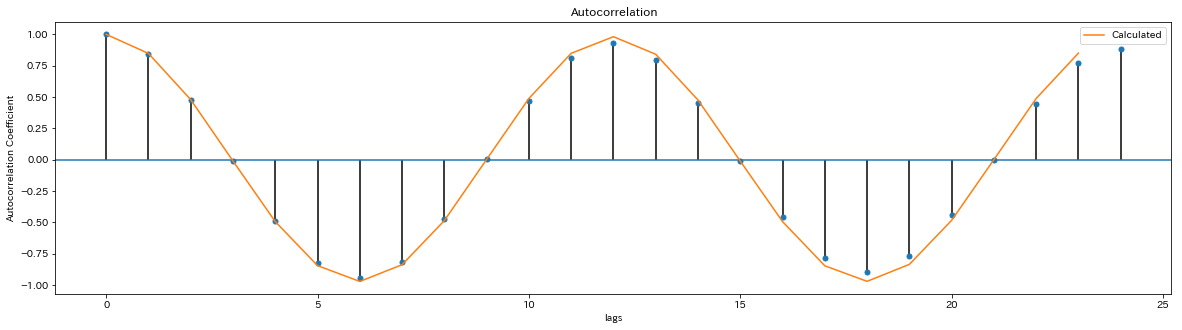

In [17]:
sm.graphics.tsa.plot_acf(ts, lags=acv_len, alpha = None)
plt.plot(acv_all, label="Calculated")
plt.xlabel("lags")
plt.ylabel("Autocorrelation Coefficient")
plt.legend()
plt.show()

# 時系列分析 by 統計学的手法

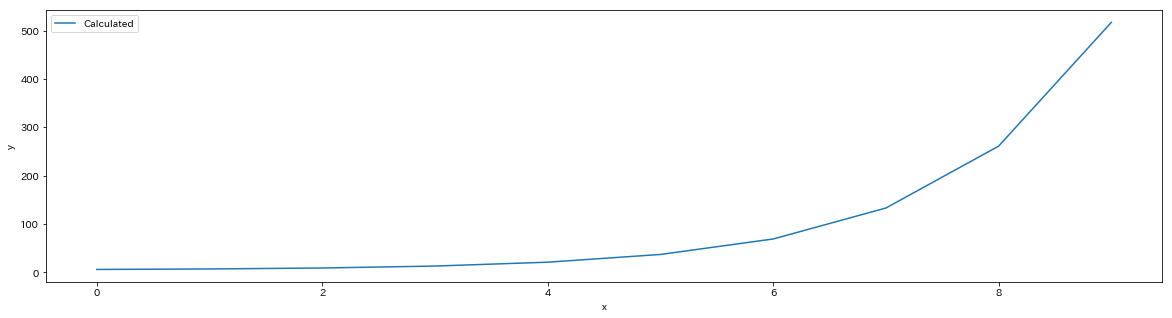

In [18]:
x = np.array(range(0, 10))
y = 2**x + 5
plt.plot(x, y, label="Calculated")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [19]:
from statsmodels.tsa import stattools as st

In [20]:
st.adfuller(ts.values.ravel())

(-4.370883323806928,
 0.0003341033996174608,
 15,
 225,
 {'1%': -3.4597521044060353,
  '5%': -2.874472927517147,
  '10%': -2.5736628197530864},
 733.9882718343765)

In [21]:
# データの長さを確認します。
print(ts.shape)

(241,)


In [22]:
# 半分くらいで学習データ、その他の（検証）データを分けます。
train_len = 120

In [23]:
# データを分割します。
train = ts[:train_len]
test = ts[train_len:]

In [24]:
# 分けることができました。
print(train.shape, test.shape)

(120,) (121,)


In [25]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
# 読み込んだモジュールを設定します。
model_ar = AR
model_arma = ARMA
model_arima = ARIMA
model_sarima = SARIMAX

In [27]:
# AR、ARMAを計算します。
result_ar = model_ar(train).fit(ic='aic')
result_arma = model_arma(train, order=[1, 1]).fit(ic='aic')

C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [28]:
predict_ar = result_ar.predict(train_len, ts.shape[0])
predict_arma = result_arma.predict(train_len, ts.shape[0])

C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


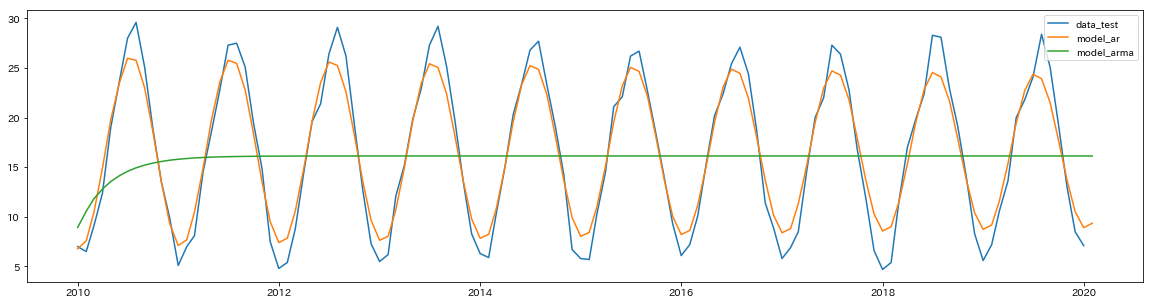

In [29]:
plt.plot(test, label="data_test")
plt.plot(predict_ar, label="model_ar")
plt.plot(predict_arma, label="model_arma")
plt.legend()
plt.show()

In [30]:
columns = ['params', 'aic']

In [31]:
# AR
result_test = pd.DataFrame(columns=columns)
num = 0
for p in range(1, 51):
    test_params = "p=%d" % p
    print(test_params)
    test_aic = model_ar(train).fit(ic='aic', maxlag=p).aic
    test_app = pd.Series(data=[test_params, test_aic], index=columns, name=num)
    result_test = result_test.append(test_app)
    num += 1

p=1
p=2
p=3
p=4
p=5
p=6
p=7
p=8
p=9
p=10
p=11
p=12
p=13
p=14
p=15
p=16
p=17
p=18
p=19


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No

p=20
p=21
p=22
p=23
p=24
p=25
p=26
p=27
p=28
p=29


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No

p=30
p=31
p=32
p=33
p=34
p=35
p=36


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No

p=37
p=38
p=39
p=40
p=41


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No

p=42
p=43
p=44
p=45


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No

p=46
p=47
p=48
p=49

C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



p=50


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [32]:
result_test.sort_values(by='aic').head(5)

,params,aic
49,p=50,0.495687
31,p=32,0.495687
32,p=33,0.495687
36,p=37,0.495687
34,p=35,0.505825


In [33]:
result_test = pd.DataFrame(columns=columns)
num = 0
for p in range(3, 7):
    for q in range(2):
        test_params = "p=%d, q=%d" % (p, q)
        print(test_params)
        test_aic = model_arma(train, order=[p, q]).fit(ic='aic').aic
        test_app = pd.Series(data=[test_params, test_aic], index=columns, name=num)
        result_test = result_test.append(test_app)
        num += 1

p=3, q=0
p=3, q=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, q=0
p=4, q=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, q=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, q=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, q=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, q=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [34]:
result_test.sort_values(by='aic').head(5)

,params,aic
7,"p=6, q=1",433.980456
5,"p=5, q=1",434.874555
6,"p=6, q=0",435.315563
3,"p=4, q=1",435.340541
1,"p=3, q=1",439.657904


In [35]:
result_test = pd.DataFrame(columns=columns)
num = 0
for p in range(3, 7):
    for d in range(1, 3):
        for q in range(2, 3):
            for sp in range(2): # 0or1
                for sd in range(2):
                    for sq in range(2):
                        test_params = "p=%d, d=%d, q=%d, sp=%d, sd=%d, sq=%d" % (p, d, q, sp, sd, sq)
                        print(test_params)
                        test_aic = model_sarima(train,
                                                order=[p, d, q],
                                                seasonal_order=[sp, sd, sq, 12], # 12ヶ月周期
                                                force_stationarity = False,
                                                enforce_invertibility = False,
                                                ensure_invertibility = False,
                                                enforce_stationarity = False,
                                               ).fit(ic='aic').aic
                        test_app = pd.Series(data=[test_params, test_aic], index=columns, name=num)
                        result_test = result_test.append(test_app)
                        num += 1

p=3, d=1, q=2, sp=0, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=1, q=2, sp=0, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=1, q=2, sp=0, sd=1, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=1, q=2, sp=0, sd=1, sq=1
p=3, d=1, q=2, sp=1, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=1, q=2, sp=1, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=1, q=2, sp=1, sd=1, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=1, q=2, sp=1, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=2, q=2, sp=0, sd=0, sq=0
p=3, d=2, q=2, sp=0, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=2, q=2, sp=0, sd=1, sq=0
p=3, d=2, q=2, sp=0, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=2, q=2, sp=1, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=2, q=2, sp=1, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=3, d=2, q=2, sp=1, sd=1, sq=0
p=3, d=2, q=2, sp=1, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=1, q=2, sp=0, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=1, q=2, sp=0, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=1, q=2, sp=0, sd=1, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=1, q=2, sp=0, sd=1, sq=1
p=4, d=1, q=2, sp=1, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=1, q=2, sp=1, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=1, q=2, sp=1, sd=1, sq=0
p=4, d=1, q=2, sp=1, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=2, q=2, sp=0, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=2, q=2, sp=0, sd=0, sq=1
p=4, d=2, q=2, sp=0, sd=1, sq=0
p=4, d=2, q=2, sp=0, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=2, q=2, sp=1, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=2, q=2, sp=1, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=4, d=2, q=2, sp=1, sd=1, sq=0
p=4, d=2, q=2, sp=1, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=1, q=2, sp=0, sd=0, sq=0
p=5, d=1, q=2, sp=0, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=1, q=2, sp=0, sd=1, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=1, q=2, sp=0, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=1, q=2, sp=1, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=1, q=2, sp=1, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=1, q=2, sp=1, sd=1, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=1, q=2, sp=1, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=2, q=2, sp=0, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=2, q=2, sp=0, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=2, q=2, sp=0, sd=1, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=2, q=2, sp=0, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=2, q=2, sp=1, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=2, q=2, sp=1, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=5, d=2, q=2, sp=1, sd=1, sq=0
p=5, d=2, q=2, sp=1, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=1, q=2, sp=0, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=1, q=2, sp=0, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=1, q=2, sp=0, sd=1, sq=0
p=6, d=1, q=2, sp=0, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=1, q=2, sp=1, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=1, q=2, sp=1, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=1, q=2, sp=1, sd=1, sq=0
p=6, d=1, q=2, sp=1, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=2, q=2, sp=0, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=2, q=2, sp=0, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=2, q=2, sp=0, sd=1, sq=0
p=6, d=2, q=2, sp=0, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=2, q=2, sp=1, sd=0, sq=0


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=2, q=2, sp=1, sd=0, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


p=6, d=2, q=2, sp=1, sd=1, sq=0
p=6, d=2, q=2, sp=1, sd=1, sq=1


C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [36]:
result_test.sort_values(by='aic').head(5)

,params,aic
55,"p=6, d=1, q=2, sp=1, sd=1, sq=1",299.974251
3,"p=3, d=1, q=2, sp=0, sd=1, sq=1",301.274574
39,"p=5, d=1, q=2, sp=1, sd=1, sq=1",302.585674
19,"p=4, d=1, q=2, sp=0, sd=1, sq=1",302.796710
35,"p=5, d=1, q=2, sp=0, sd=1, sq=1",304.683979


In [37]:
result_ar = model_ar(train).fit(ic='aic', maxlag=50)
result_arma = model_arma(train, order=[6, 1]).fit(ic='aic')
result_sarima = model_sarima(
    train, order=[6, 1, 2],
    seasonal_order=[1, 1, 1, 12],
    force_stationarity = False,
    enforce_invertibility = False,
    ensure_invertibility = False,
    enforce_stationarity = False,
).fit(ic='aic')

C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [38]:
predict_ar = result_ar.predict(train_len, ts.shape[0])
predict_arma = result_arma.predict(train_len, ts.shape[0])
predict_sarima = result_sarima.predict(train_len, ts.shape[0])

C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


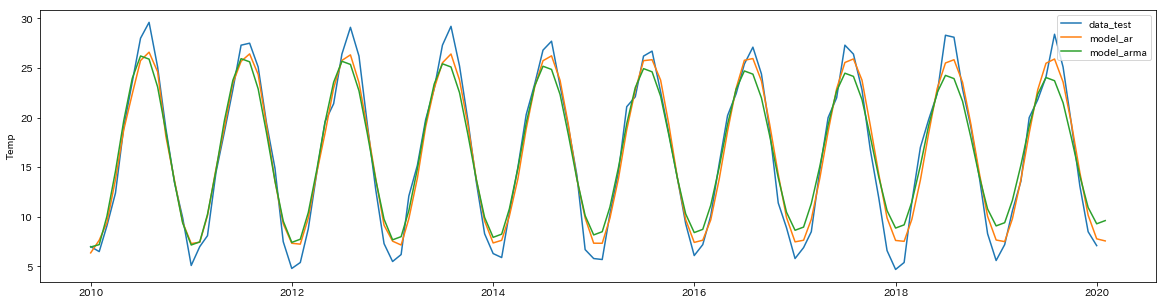

In [39]:
plt.plot(test, label="data_test")
plt.plot(predict_ar, label="model_ar")
plt.plot(predict_arma, label="model_arma")
plt.ylabel('Temp')
plt.legend()
plt.show()

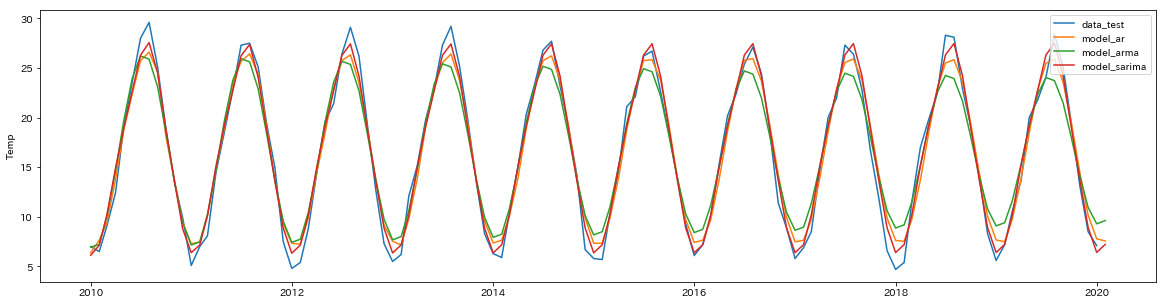

In [40]:
plt.plot(test, label="data_test")
plt.plot(predict_ar, label="model_ar")
plt.plot(predict_arma, label="model_arma")
plt.plot(predict_sarima, label="model_sarima")
plt.ylabel('Temp')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error

In [42]:
print("AR RMSE：", mean_squared_error(test, predict_ar[:121]))
print("ARMA RMSE：", mean_squared_error(test, predict_arma[:121]))
print("SARIMA RMSE：", mean_squared_error(test, predict_sarima[:121]))

AR RMSE： 2.1711343296843384
ARMA RMSE： 3.7366434743487695
SARIMA RMSE： 1.1923929079087516


# 時系列分析 by RNN, LSTM, GRU

In [43]:
data_base = ts

In [44]:
ts_size = 6 # 時系列の長さを設定（SARIMAのパラメータpが6だったため）
len_size = len(data_base)
shape_size = len_size - ts_size

In [45]:
data_x = []
data_y = []
for i in range(shape_size):
    i_for = len_size - shape_size + i
    data_x.append(data_base[i:i_for])
    data_y.append(data_base[i_for])
data_x = np.array(data_x)
data_y = np.array(data_y)

In [46]:
print(data_x.shape, data_y.shape)

(235, 6) (235,)


In [47]:
X_train = data_x[:train_len]
X_test = data_x[train_len:]
y_train = data_y[:train_len]
y_test = data_y[train_len:]

In [48]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [49]:
print(X_train.shape, X_test.shape)

(120, 1, 6) (115, 1, 6)


In [50]:
from keras import models, layers, metrics

Using TensorFlow backend.
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\m.saito\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\m.sai

In [208]:
model_rnn = models.Sequential()
model_rnn.add(layers.SimpleRNN(100, activation='tanh', input_shape=(1, ts_size)))
model_rnn.add(layers.Dense(1))
model_rnn.add(layers.Activation("linear"))
model_rnn.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])

In [209]:
model_lstm = models.Sequential()
model_lstm.add(layers.LSTM(100, activation='tanh', input_shape=(1, ts_size)))
model_lstm.add(layers.Dense(1))
model_lstm.add(layers.Activation("linear"))
model_lstm.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])

In [210]:
model_gru = models.Sequential()
model_gru.add(layers.GRU(100, activation='tanh', input_shape=(1, ts_size)))
model_gru.add(layers.Dense(1))
model_gru.add(layers.Activation("linear"))
model_gru.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])

In [211]:
print("# start RNN") # batch_sizeを1、シャッフルを禁止にすることがポイントです
his_rnn = model_rnn.fit(X_train, y_train, batch_size=1, epochs=5, verbose=1, shuffle=False, validation_data=(X_test, y_test))
print("# start LSTM")
his_lstm = model_lstm.fit(X_train, y_train, batch_size=1, epochs=5, verbose=1, shuffle=False, validation_data=(X_test, y_test))
print("# start GRU")
his_gru = model_gru.fit(X_train, y_train, batch_size=1, epochs=5, verbose=1, shuffle=False, validation_data=(X_test, y_test))

# start RNN
Train on 120 samples, validate on 115 samples
Epoch 1/5
120/120 [==============================] - 1s 11ms/step - loss: 143.5023 - mean_absolute_error: 9.6087 - val_loss: 62.6639 - val_mean_absolute_error: 6.6291
Epoch 2/5
120/120 [==============================] - 0s 4ms/step - loss: 35.8986 - mean_absolute_error: 4.9338 - val_loss: 21.1066 - val_mean_absolute_error: 3.8703
Epoch 3/5
120/120 [==============================] - 1s 4ms/step - loss: 12.1126 - mean_absolute_error: 2.8583 - val_loss: 7.9993 - val_mean_absolute_error: 2.3355
Epoch 4/5
120/120 [==============================] - 1s 4ms/step - loss: 5.0948 - mean_absolute_error: 1.7918 - val_loss: 4.1235 - val_mean_absolute_error: 1.7321
Epoch 5/5
120/120 [==============================] - 1s 4ms/step - loss: 2.9757 - mean_absolute_error: 1.3910 - val_loss: 2.7430 - val_mean_absolute_error: 1.4026
# start LSTM
Train on 120 samples, validate on 115 samples
Epoch 1/5
120/120 [==============================] - 1s 12ms/

In [212]:
predict_rnn = model_rnn.predict(X_test)
predict_lstm = model_lstm.predict(X_test)
predict_gru = model_gru.predict(X_test)

In [213]:
print("RNN RMSE：", mean_squared_error(y_test, predict_rnn))
print("LSTM RMSE：", mean_squared_error(y_test, predict_lstm))
print("GRU RMSE：", mean_squared_error(y_test, predict_gru))

RNN RMSE： 2.742967746786882
LSTM RMSE： 4.0562749284183335
GRU RMSE： 2.312132536730048


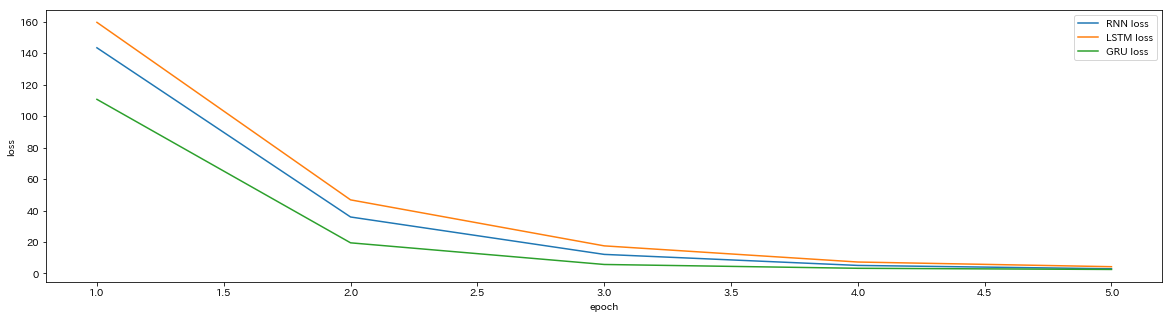

In [214]:
epochs = range(1, len(his_rnn.history['loss']) + 1)
plt.plot(epochs, his_rnn.history['loss'], label='RNN loss')
plt.plot(epochs, his_lstm.history['loss'], label='LSTM loss')
plt.plot(epochs, his_gru.history['loss'], label='GRU loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [231]:
model_gru2 = models.Sequential() # 前回と同じように設定します。
model_gru2.add(layers.GRU(100,
                               activation='tanh',
                               input_shape=(1, ts_size)
                              )
             )
model_gru2.add(layers.Dense(1))
model_gru2.add(layers.Activation("linear"))
model_gru2.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])

In [232]:
model_gru3 = models.Sequential()
model_gru3.add(layers.GRU(100,
                               activation='tanh',
                               dropout=0.2, # dropoutを追加
                               recurrent_dropout=0.2,
                               input_shape=(1, ts_size)
                              )
             )
model_gru3.add(layers.Dense(1))
model_gru3.add(layers.Activation("linear"))
model_gru3.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])

In [233]:
model_gru4 = models.Sequential()
model_gru4.add(layers.GRU(100,
                               activation='relu', # 活性化関数をreluに変更
                               input_shape=(1, ts_size)
                              )
             )
model_gru4.add(layers.Dense(1))
model_gru4.add(layers.Activation("linear"))
model_gru4.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])

In [234]:
# 学習回数を増やします
print("# start GRU2")
his_gru2 = model_gru2.fit(X_train, y_train, batch_size=1, epochs=200, verbose=1, shuffle=False, validation_data=(X_test, y_test))
print("# start GRU3")
his_gru3 = model_gru3.fit(X_train, y_train, batch_size=1, epochs=200, verbose=1, shuffle=False, validation_data=(X_test, y_test))
print("# start GRU4")
his_gru4 = model_gru4.fit(X_train, y_train, batch_size=1, epochs=200, verbose=1, shuffle=False, validation_data=(X_test, y_test))

# start GRU2
Train on 120 samples, validate on 115 samples
Epoch 1/200
120/120 [==============================] - 2s 14ms/step - loss: 127.2365 - mean_absolute_error: 8.8724 - val_loss: 52.2132 - val_mean_absolute_error: 6.1142
Epoch 2/200
120/120 [==============================] - 1s 5ms/step - loss: 29.4966 - mean_absolute_error: 4.4984 - val_loss: 17.6715 - val_mean_absolute_error: 3.4731
Epoch 3/200
120/120 [==============================] - 1s 5ms/step - loss: 10.0835 - mean_absolute_error: 2.5771 - val_loss: 6.3330 - val_mean_absolute_error: 2.0357
Epoch 4/200
120/120 [==============================] - 1s 5ms/step - loss: 4.4494 - mean_absolute_error: 1.6505 - val_loss: 3.9003 - val_mean_absolute_error: 1.6788
Epoch 5/200
120/120 [==============================] - 1s 5ms/step - loss: 3.3093 - mean_absolute_error: 1.4393 - val_loss: 3.0512 - val_mean_absolute_error: 1.4933
Epoch 6/200
120/120 [==============================] - 1s 5ms/step - loss: 2.7206 - mean_absolute_error: 1.31

120/120 [==============================] - 1s 5ms/step - loss: 1.5193 - mean_absolute_error: 0.9787 - val_loss: 1.3373 - val_mean_absolute_error: 0.9562
Epoch 51/200
120/120 [==============================] - 1s 5ms/step - loss: 1.5176 - mean_absolute_error: 0.9783 - val_loss: 1.3339 - val_mean_absolute_error: 0.9548
Epoch 52/200
120/120 [==============================] - 1s 5ms/step - loss: 1.5161 - mean_absolute_error: 0.9779 - val_loss: 1.3306 - val_mean_absolute_error: 0.9535
Epoch 53/200
120/120 [==============================] - 1s 5ms/step - loss: 1.5145 - mean_absolute_error: 0.9774 - val_loss: 1.3274 - val_mean_absolute_error: 0.9523
Epoch 54/200
120/120 [==============================] - 1s 5ms/step - loss: 1.5130 - mean_absolute_error: 0.9769 - val_loss: 1.3242 - val_mean_absolute_error: 0.9510
Epoch 55/200
120/120 [==============================] - 1s 5ms/step - loss: 1.5115 - mean_absolute_error: 0.9764 - val_loss: 1.3212 - val_mean_absolute_error: 0.9497
Epoch 56/200
120/

120/120 [==============================] - 1s 5ms/step - loss: 1.4183 - mean_absolute_error: 0.9184 - val_loss: 1.2808 - val_mean_absolute_error: 0.9026
Epoch 149/200
120/120 [==============================] - 1s 5ms/step - loss: 1.4175 - mean_absolute_error: 0.9181 - val_loss: 1.2817 - val_mean_absolute_error: 0.9027
Epoch 150/200
120/120 [==============================] - 1s 5ms/step - loss: 1.4169 - mean_absolute_error: 0.9178 - val_loss: 1.2826 - val_mean_absolute_error: 0.9028
Epoch 151/200
120/120 [==============================] - 1s 5ms/step - loss: 1.4163 - mean_absolute_error: 0.9175 - val_loss: 1.2836 - val_mean_absolute_error: 0.9031
Epoch 152/200
120/120 [==============================] - 1s 5ms/step - loss: 1.4158 - mean_absolute_error: 0.9173 - val_loss: 1.2846 - val_mean_absolute_error: 0.9033
Epoch 153/200
120/120 [==============================] - 1s 5ms/step - loss: 1.4154 - mean_absolute_error: 0.9171 - val_loss: 1.2856 - val_mean_absolute_error: 0.9039
Epoch 154/20

Epoch 46/200
120/120 [==============================] - 1s 5ms/step - loss: 6.6241 - mean_absolute_error: 1.8689 - val_loss: 2.7416 - val_mean_absolute_error: 1.3435
Epoch 47/200
120/120 [==============================] - 1s 5ms/step - loss: 3.7906 - mean_absolute_error: 1.5370 - val_loss: 2.0783 - val_mean_absolute_error: 1.1752
Epoch 48/200
120/120 [==============================] - 1s 5ms/step - loss: 6.9065 - mean_absolute_error: 1.6965 - val_loss: 2.1745 - val_mean_absolute_error: 1.2000
Epoch 49/200
120/120 [==============================] - 1s 5ms/step - loss: 5.0735 - mean_absolute_error: 1.6738 - val_loss: 2.7216 - val_mean_absolute_error: 1.3540
Epoch 50/200
120/120 [==============================] - 1s 5ms/step - loss: 6.1832 - mean_absolute_error: 1.8849 - val_loss: 2.1291 - val_mean_absolute_error: 1.1970
Epoch 51/200
120/120 [==============================] - 1s 6ms/step - loss: 4.8586 - mean_absolute_error: 1.6852 - val_loss: 3.0490 - val_mean_absolute_error: 1.4257
Epoc

120/120 [==============================] - 1s 5ms/step - loss: 3.0988 - mean_absolute_error: 1.3573 - val_loss: 2.5948 - val_mean_absolute_error: 1.3367
Epoch 145/200
120/120 [==============================] - 1s 5ms/step - loss: 2.7727 - mean_absolute_error: 1.3287 - val_loss: 3.2362 - val_mean_absolute_error: 1.5097
Epoch 146/200
120/120 [==============================] - 1s 5ms/step - loss: 2.8214 - mean_absolute_error: 1.3127 - val_loss: 2.5313 - val_mean_absolute_error: 1.3280
Epoch 147/200
120/120 [==============================] - 1s 6ms/step - loss: 3.0338 - mean_absolute_error: 1.4193 - val_loss: 2.7017 - val_mean_absolute_error: 1.3691
Epoch 148/200
120/120 [==============================] - 1s 5ms/step - loss: 3.0941 - mean_absolute_error: 1.4070 - val_loss: 2.4433 - val_mean_absolute_error: 1.3065
Epoch 149/200
120/120 [==============================] - 1s 5ms/step - loss: 3.0748 - mean_absolute_error: 1.2951 - val_loss: 2.2316 - val_mean_absolute_error: 1.2500
Epoch 150/20

120/120 [==============================] - 1s 5ms/step - loss: 2.4565 - mean_absolute_error: 1.2206 - val_loss: 3.4943 - val_mean_absolute_error: 1.4916
Epoch 43/200
120/120 [==============================] - 1s 5ms/step - loss: 2.4411 - mean_absolute_error: 1.2170 - val_loss: 3.6193 - val_mean_absolute_error: 1.5185
Epoch 44/200
120/120 [==============================] - 1s 5ms/step - loss: 2.4240 - mean_absolute_error: 1.2130 - val_loss: 3.5571 - val_mean_absolute_error: 1.5050
Epoch 45/200
120/120 [==============================] - 1s 5ms/step - loss: 2.4079 - mean_absolute_error: 1.2082 - val_loss: 3.6211 - val_mean_absolute_error: 1.5191
Epoch 46/200
120/120 [==============================] - 1s 5ms/step - loss: 2.3937 - mean_absolute_error: 1.2044 - val_loss: 3.6902 - val_mean_absolute_error: 1.5353
Epoch 47/200
120/120 [==============================] - 1s 5ms/step - loss: 2.3779 - mean_absolute_error: 1.2016 - val_loss: 3.6566 - val_mean_absolute_error: 1.5261
Epoch 48/200
120/

120/120 [==============================] - 1s 5ms/step - loss: 1.8892 - mean_absolute_error: 1.0628 - val_loss: 2.9964 - val_mean_absolute_error: 1.3498
Epoch 141/200
120/120 [==============================] - 1s 5ms/step - loss: 1.8902 - mean_absolute_error: 1.0631 - val_loss: 2.9211 - val_mean_absolute_error: 1.3378
Epoch 142/200
120/120 [==============================] - 1s 5ms/step - loss: 1.8860 - mean_absolute_error: 1.0607 - val_loss: 2.9565 - val_mean_absolute_error: 1.3407
Epoch 143/200
120/120 [==============================] - 1s 5ms/step - loss: 1.8875 - mean_absolute_error: 1.0605 - val_loss: 2.8769 - val_mean_absolute_error: 1.3265
Epoch 144/200
120/120 [==============================] - 1s 5ms/step - loss: 1.8870 - mean_absolute_error: 1.0610 - val_loss: 2.9725 - val_mean_absolute_error: 1.3433
Epoch 145/200
120/120 [==============================] - 1s 5ms/step - loss: 1.8833 - mean_absolute_error: 1.0597 - val_loss: 2.9030 - val_mean_absolute_error: 1.3314
Epoch 146/20

In [235]:
predict_gru2 = model_gru2.predict(X_test)
predict_gru3 = model_gru3.predict(X_test)
predict_gru4 = model_gru4.predict(X_test)

In [236]:
print("GRU2 RMSE：", mean_squared_error(y_test, predict_gru2)) # 前回同様
print("GRU3 RMSE：", mean_squared_error(y_test, predict_gru3)) # G2+dropout追加で過学習軽減
print("GRU4 RMSE：", mean_squared_error(y_test, predict_gru4)) # G2+活性化関数をreluに変更

GRU2 RMSE： 1.3479487102554695
GRU3 RMSE： 2.652635035418319
GRU4 RMSE： 2.8156458046941175


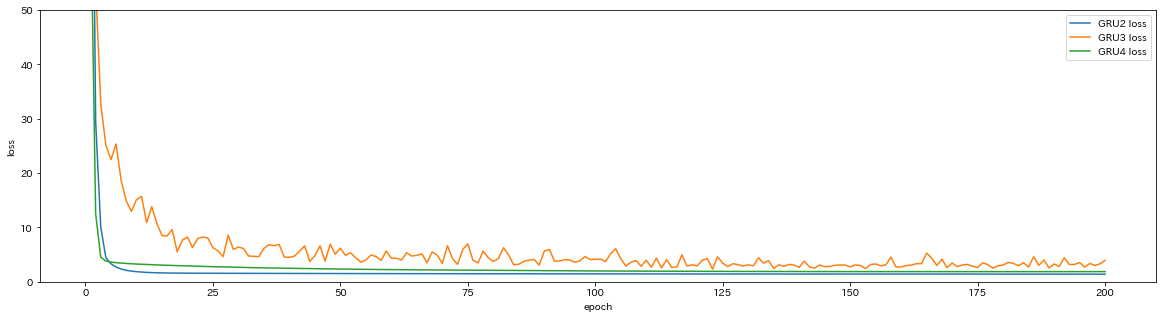

In [240]:
epochs = range(1, len(his_gru2.history['loss']) + 1)
plt.plot(epochs, his_gru2.history['loss'], label='GRU2 loss')
plt.plot(epochs, his_gru3.history['loss'], label='GRU3 loss')
plt.plot(epochs, his_gru4.history['loss'], label='GRU4 loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 50)
plt.legend()
plt.show()

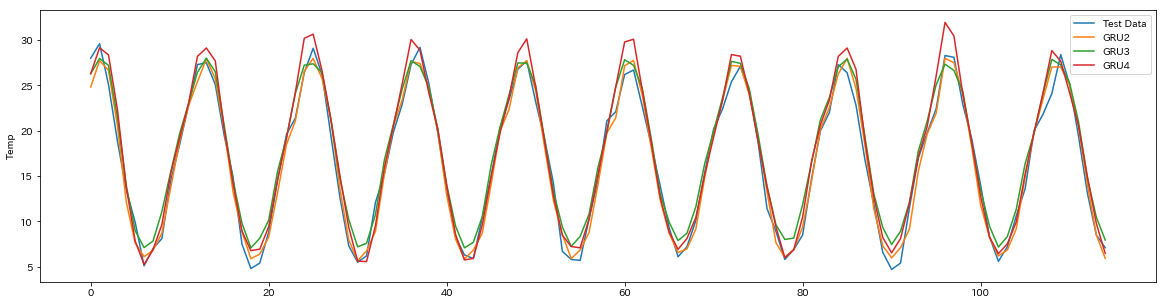

In [241]:
plt.plot(y_test, label='Test Data')
plt.plot(predict_gru2, label='GRU2')
plt.plot(predict_gru3, label='GRU3')
plt.plot(predict_gru4, label='GRU4')
plt.ylabel('Temp')
plt.legend()
plt.show()

# 問1・問2 回答例

# (1) 正規化

In [262]:
# 正規化処理
def scaler_minmax(base_data, ex_data):
    pp_data = []
    for i in ex_data:
        pp_data.append((i - np.min(base_data)) / (np.max(base_data) - np.min(base_data)))
    return np.array(pp_data)

In [281]:
# 正規化を戻します
def scaler_minmax_rescale(base_data, ex_data):
    pp_data = []
    for sc in ex_data:
        pp_data.append(sc * (np.max(base_data) - np.min(base_data)) + np.min(base_data))
    return np.array(pp_data)

In [263]:
# scalerが使えないので下記で処理
list_x = []
for x in X_train:
    list_x.extend(x[0])
list_x = np.array(list_x).reshape(1, -1)

In [264]:
y_train_sc = scaler_minmax(list_x, y_train)
y_test_sc = scaler_minmax(list_x, y_test)

In [275]:
X_train_sc = []
for i in X_train:
    X_train_sc.append(scaler_minmax(list_x, i[0]))
X_train_sc = np.array(X_train_sc)

In [276]:
X_test_sc = []
for i in X_test:
    X_test_sc.append(scaler_minmax(list_x, i[0]))
X_test_sc = np.array(X_test_sc)

In [277]:
X_train_sc = np.reshape(X_train_sc, (X_train_sc.shape[0], 1, X_train_sc.shape[1]))
X_test_sc = np.reshape(X_test_sc, (X_test_sc.shape[0], 1, X_test_sc.shape[1]))

In [282]:
model_ans1 = models.Sequential() # 講義のGRU2と同じように設定します。
model_ans1.add(layers.GRU(100,
                               activation='tanh',
                               input_shape=(1, ts_size)
                              )
             )
model_ans1.add(layers.Dense(1))
model_ans1.add(layers.Activation("linear"))
model_ans1.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])

In [283]:
print("# start ANS1")
his_ans1 = model_ans1.fit(X_train_sc, y_train_sc, batch_size=1, epochs=300, verbose=1, shuffle=False, validation_data=(X_test_sc, y_test_sc))

# start ANS1
Train on 120 samples, validate on 115 samples
Epoch 1/300
120/120 [==============================] - 2s 15ms/step - loss: 0.1019 - mean_absolute_error: 0.2609 - val_loss: 0.0246 - val_mean_absolute_error: 0.1408
Epoch 2/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0094 - mean_absolute_error: 0.0769 - val_loss: 0.0035 - val_mean_absolute_error: 0.0472
Epoch 3/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0517 - val_loss: 0.0034 - val_mean_absolute_error: 0.0469
Epoch 4/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0034 - val_mean_absolute_error: 0.0466
Epoch 5/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0041 - mean_absolute_error: 0.0502 - val_loss: 0.0034 - val_mean_absolute_error: 0.0464
Epoch 6/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0040 - mean_absolute_error: 0.0496 - v

120/120 [==============================] - 1s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0431 - val_loss: 0.0038 - val_mean_absolute_error: 0.0499
Epoch 51/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0430 - val_loss: 0.0038 - val_mean_absolute_error: 0.0499
Epoch 52/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0430 - val_loss: 0.0038 - val_mean_absolute_error: 0.0499
Epoch 53/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0430 - val_loss: 0.0038 - val_mean_absolute_error: 0.0499
Epoch 54/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0430 - val_loss: 0.0038 - val_mean_absolute_error: 0.0499
Epoch 55/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0429 - val_loss: 0.0038 - val_mean_absolute_error: 0.0499
Epoch 56/300
120/

120/120 [==============================] - 1s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0412 - val_loss: 0.0035 - val_mean_absolute_error: 0.0479
Epoch 149/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0412 - val_loss: 0.0035 - val_mean_absolute_error: 0.0479
Epoch 150/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0412 - val_loss: 0.0034 - val_mean_absolute_error: 0.0479
Epoch 151/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0412 - val_loss: 0.0034 - val_mean_absolute_error: 0.0479
Epoch 152/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0411 - val_loss: 0.0034 - val_mean_absolute_error: 0.0478
Epoch 153/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0411 - val_loss: 0.0034 - val_mean_absolute_error: 0.0478
Epoch 154/30

120/120 [==============================] - 1s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0402 - val_loss: 0.0031 - val_mean_absolute_error: 0.0455
Epoch 247/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0402 - val_loss: 0.0031 - val_mean_absolute_error: 0.0455
Epoch 248/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0401 - val_loss: 0.0031 - val_mean_absolute_error: 0.0455
Epoch 249/300
120/120 [==============================] - 1s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0401 - val_loss: 0.0031 - val_mean_absolute_error: 0.0454
Epoch 250/300
120/120 [==============================] - 1s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0401 - val_loss: 0.0031 - val_mean_absolute_error: 0.0454
Epoch 251/300
120/120 [==============================] - 1s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0401 - val_loss: 0.0031 - val_mean_absolute_error: 0.0454
Epoch 252/30

In [289]:
predict_ans1_sc = model_ans1.predict(X_test_sc)
predict_ans1 = scaler_minmax_rescale(list_x, predict_ans1_sc) # もとの値に戻します
y_test = scaler_minmax_rescale(list_x, y_test_sc)

In [290]:
print("ANS1 RMSE：", mean_squared_error(y_test, predict_ans1))

ANS1 RMSE： 1.6767458119902163


# (2) 時系列データの長さ調整

In [54]:
columns = ['params', 'RMSE']
result_test = pd.DataFrame(columns=columns)
j = 0
for i in range(1, 110):
    print("#----------------------------------------------#")
    print("# Start Calc >> Data Length %s" % i)
    print("#----------------------------------------------#")
    
    # 時系列の長さを設定
    ts_size = i
    len_size = len(data_base)
    shape_size = len_size - ts_size
    
    # データを分割
    data_x = []
    data_y = []
    for k in range(shape_size):
        k_for = len_size - shape_size + k
        data_x.append(data_base[k:k_for])
        data_y.append(data_base[k_for])
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    
    # train, testへ変換
    X_train = data_x[:train_len]
    X_test = data_x[train_len:]
    y_train = data_y[:train_len]
    y_test = data_y[train_len:]
    
    # 形式を設定
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    # モデルの再設定
    model_ans2 = models.Sequential()
    model_ans2.add(layers.GRU(75, # 学習速度確保のためにGRUに、層を75あたりにすると良い。
                              activation='tanh',
                              input_shape=(1, ts_size)
                             )
                  )
    model_ans2.add(layers.Dense(1))
    model_ans2.add(layers.Activation("linear"))
    model_ans2.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])
    
    # 学習
    model_ans2.fit(X_train, y_train, batch_size=1, epochs=50, verbose=1, shuffle=False, validation_data=(X_test, y_test))
    
    # 計算
    test_value = mean_squared_error(y_test, model_ans2.predict(X_test))
    print("RMSE：", test_value)
    result_test = result_test.append(pd.Series(data=["p=%s" % i, test_value], index=columns, name=j))
    j += 1

#----------------------------------------------#
# Start Calc >> Data Length 1
#----------------------------------------------#
Train on 120 samples, validate on 120 samples
Epoch 1/50
120/120 [==============================] - 1s 7ms/step - loss: 168.2215 - mean_absolute_error: 10.9545 - val_loss: 88.2106 - val_mean_absolute_error: 7.5666
Epoch 2/50
120/120 [==============================] - 0s 4ms/step - loss: 51.3764 - mean_absolute_error: 5.8615 - val_loss: 34.8542 - val_mean_absolute_error: 5.0414
Epoch 3/50
120/120 [==============================] - 0s 4ms/step - loss: 27.6013 - mean_absolute_error: 4.4458 - val_loss: 25.0900 - val_mean_absolute_error: 4.2408
Epoch 4/50
120/120 [==============================] - 1s 4ms/step - loss: 21.6716 - mean_absolute_error: 3.9526 - val_loss: 21.2275 - val_mean_absolute_error: 3.9680
Epoch 5/50
120/120 [==============================] - 0s 4ms/step - loss: 19.1209 - mean_absolute_error: 3.7569 - val_loss: 19.5592 - val_mean_absolute_error: 3

120/120 [==============================] - 0s 4ms/step - loss: 16.1735 - mean_absolute_error: 3.5095 - val_loss: 17.1308 - val_mean_absolute_error: 3.6785
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 16.1686 - mean_absolute_error: 3.5095 - val_loss: 17.1249 - val_mean_absolute_error: 3.6776
RMSE： 17.124938570134372
#----------------------------------------------#
# Start Calc >> Data Length 2
#----------------------------------------------#
Train on 120 samples, validate on 119 samples
Epoch 1/50
120/120 [==============================] - 1s 7ms/step - loss: 165.5054 - mean_absolute_error: 10.7236 - val_loss: 73.8056 - val_mean_absolute_error: 7.1182
Epoch 2/50
120/120 [==============================] - 0s 4ms/step - loss: 44.9293 - mean_absolute_error: 5.6550 - val_loss: 31.8037 - val_mean_absolute_error: 4.8394
Epoch 3/50
120/120 [==============================] - 0s 4ms/step - loss: 22.2507 - mean_absolute_error: 3.9597 - val_loss: 16.8514 - val_mean_ab

120/120 [==============================] - 0s 4ms/step - loss: 2.6088 - mean_absolute_error: 1.2767 - val_loss: 2.4622 - val_mean_absolute_error: 1.2853
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 2.6034 - mean_absolute_error: 1.2746 - val_loss: 2.4556 - val_mean_absolute_error: 1.2828
Epoch 47/50
120/120 [==============================] - 0s 4ms/step - loss: 2.5981 - mean_absolute_error: 1.2726 - val_loss: 2.4489 - val_mean_absolute_error: 1.2804
Epoch 48/50
120/120 [==============================] - 0s 4ms/step - loss: 2.5930 - mean_absolute_error: 1.2706 - val_loss: 2.4423 - val_mean_absolute_error: 1.2780
Epoch 49/50
120/120 [==============================] - 0s 4ms/step - loss: 2.5880 - mean_absolute_error: 1.2686 - val_loss: 2.4358 - val_mean_absolute_error: 1.2756
Epoch 50/50
120/120 [==============================] - 0s 4ms/step - loss: 2.5832 - mean_absolute_error: 1.2667 - val_loss: 2.4294 - val_mean_absolute_error: 1.2733
RMSE： 2.42935984932288

120/120 [==============================] - 0s 4ms/step - loss: 1.6279 - mean_absolute_error: 0.9755 - val_loss: 1.5093 - val_mean_absolute_error: 1.0106
Epoch 42/50
120/120 [==============================] - 0s 4ms/step - loss: 1.6267 - mean_absolute_error: 0.9755 - val_loss: 1.5106 - val_mean_absolute_error: 1.0107
Epoch 43/50
120/120 [==============================] - 0s 4ms/step - loss: 1.6255 - mean_absolute_error: 0.9753 - val_loss: 1.5120 - val_mean_absolute_error: 1.0108
Epoch 44/50
120/120 [==============================] - 0s 4ms/step - loss: 1.6241 - mean_absolute_error: 0.9752 - val_loss: 1.5135 - val_mean_absolute_error: 1.0110
Epoch 45/50
120/120 [==============================] - 0s 4ms/step - loss: 1.6228 - mean_absolute_error: 0.9749 - val_loss: 1.5154 - val_mean_absolute_error: 1.0113
Epoch 46/50
120/120 [==============================] - 0s 4ms/step - loss: 1.6215 - mean_absolute_error: 0.9745 - val_loss: 1.5179 - val_mean_absolute_error: 1.0115
Epoch 47/50
120/120 [=

120/120 [==============================] - 0s 4ms/step - loss: 1.4336 - mean_absolute_error: 0.9758 - val_loss: 1.4096 - val_mean_absolute_error: 0.9587
Epoch 38/50
120/120 [==============================] - 0s 4ms/step - loss: 1.4333 - mean_absolute_error: 0.9757 - val_loss: 1.4093 - val_mean_absolute_error: 0.9586
Epoch 39/50
120/120 [==============================] - 0s 4ms/step - loss: 1.4329 - mean_absolute_error: 0.9756 - val_loss: 1.4086 - val_mean_absolute_error: 0.9583
Epoch 40/50
120/120 [==============================] - 0s 4ms/step - loss: 1.4323 - mean_absolute_error: 0.9755 - val_loss: 1.4073 - val_mean_absolute_error: 0.9579
Epoch 41/50
120/120 [==============================] - 0s 4ms/step - loss: 1.4315 - mean_absolute_error: 0.9752 - val_loss: 1.4056 - val_mean_absolute_error: 0.9573
Epoch 42/50
120/120 [==============================] - 0s 4ms/step - loss: 1.4307 - mean_absolute_error: 0.9748 - val_loss: 1.4035 - val_mean_absolute_error: 0.9567
Epoch 43/50
120/120 [=

KeyboardInterrupt: 

In [ ]:
result_test.sort_values(by='RMSE').head(10)

In [213]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [256]:
# 学習epoch（0～）ごとに学習率低減を実装
def step_decay(epoch):
    x = 1e-3
    if epoch >= 150:
        x = 1e-4
    return x

In [257]:
model_decay = LearningRateScheduler(step_decay, verbose=1)

In [258]:
# 重みの保存を実装
model_check = ModelCheckpoint(filepath='weight_save2.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [55]:
ts_size = 52 # 時系列の長さを設定
len_size = len(data_base)
shape_size = len_size - ts_size

In [56]:
data_x = []
data_y = []
for i in range(shape_size):
    i_for = len_size - shape_size + i
    data_x.append(data_base[i:i_for])
    data_y.append(data_base[i_for])
data_x = np.array(data_x)
data_y = np.array(data_y)

In [57]:
print(data_x.shape, data_y.shape)

(189, 52) (189,)


In [58]:
X_train = data_x[:train_len]
X_test = data_x[train_len:]
y_train = data_y[:train_len]
y_test = data_y[train_len:]

In [59]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [60]:
print(X_train.shape, X_test.shape)

(120, 1, 52) (69, 1, 52)


In [265]:
model_ans2 = models.Sequential()
model_ans2.add(layers.GRU(75,
                               activation='tanh',
                               input_shape=(1, ts_size)
                              )
             )
model_ans2.add(layers.Dense(1))
model_ans2.add(layers.Activation("linear"))
model_ans2.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])

In [266]:
print("# start ANS2")
his_ans2 = model_ans2.fit(
    X_train, y_train,
    batch_size=1, epochs=200, verbose=1, shuffle=False,
    validation_data=(X_test, y_test),
    callbacks=[model_decay, model_check]
)

# start ANS2
Train on 120 samples, validate on 69 samples
Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 2s 16ms/step - loss: 104.6484 - mean_absolute_error: 7.9544 - val_loss: 52.9586 - val_mean_absolute_error: 5.5336

Epoch 00001: val_loss improved from inf to 52.95858, saving model to weight_save.hdf5
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 36.3075 - mean_absolute_error: 4.4412 - val_loss: 18.7933 - val_mean_absolute_error: 3.1421

Epoch 00002: val_loss improved from 52.95858 to 18.79329, saving model to weight_save.hdf5
Epoch 3/200

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 13.9265 - mean_absolute_error: 2.6725 - val_loss: 6.6272 - val_mean_absolute_error: 1.8214

Epoch 00003: val_loss improved from 18.79329 to 6.62719,

120/120 [==============================] - 1s 6ms/step - loss: 1.8355 - mean_absolute_error: 1.1107 - val_loss: 2.2018 - val_mean_absolute_error: 1.1864

Epoch 00028: val_loss did not improve from 1.12671
Epoch 29/200

Epoch 00029: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 2.1360 - mean_absolute_error: 1.1910 - val_loss: 2.3651 - val_mean_absolute_error: 1.1983

Epoch 00029: val_loss did not improve from 1.12671
Epoch 30/200

Epoch 00030: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.9123 - mean_absolute_error: 1.1432 - val_loss: 1.9397 - val_mean_absolute_error: 1.0835

Epoch 00030: val_loss did not improve from 1.12671
Epoch 31/200

Epoch 00031: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 5ms/step - loss: 1.8909 - mean_absolute_error: 1.0893 - val_loss: 1.5470 - val_mean_absolute_err

120/120 [==============================] - 1s 6ms/step - loss: 1.7332 - mean_absolute_error: 1.0382 - val_loss: 1.5301 - val_mean_absolute_error: 1.0364

Epoch 00057: val_loss did not improve from 1.12671
Epoch 58/200

Epoch 00058: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.8018 - mean_absolute_error: 1.0594 - val_loss: 1.6523 - val_mean_absolute_error: 1.0630

Epoch 00058: val_loss did not improve from 1.12671
Epoch 59/200

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.4639 - mean_absolute_error: 0.9365 - val_loss: 1.6087 - val_mean_absolute_error: 1.0199

Epoch 00059: val_loss did not improve from 1.12671
Epoch 60/200

Epoch 00060: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.6467 - mean_absolute_error: 1.0340 - val_loss: 1.5169 - val_mean_absolute_err


Epoch 00085: val_loss did not improve from 1.05588
Epoch 86/200

Epoch 00086: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.4873 - mean_absolute_error: 0.9456 - val_loss: 1.3241 - val_mean_absolute_error: 0.9154

Epoch 00086: val_loss did not improve from 1.05588
Epoch 87/200

Epoch 00087: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.4792 - mean_absolute_error: 0.9801 - val_loss: 1.5374 - val_mean_absolute_error: 0.9549

Epoch 00087: val_loss did not improve from 1.05588
Epoch 88/200

Epoch 00088: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.4579 - mean_absolute_error: 1.0003 - val_loss: 1.3619 - val_mean_absolute_error: 0.9459

Epoch 00088: val_loss did not improve from 1.05588
Epoch 89/200

Epoch 00089: LearningRateScheduler setting learning rate to 0.001.
120/120 [

120/120 [==============================] - 1s 6ms/step - loss: 1.4332 - mean_absolute_error: 0.9295 - val_loss: 1.3697 - val_mean_absolute_error: 0.9382

Epoch 00143: val_loss did not improve from 1.05588
Epoch 144/200

Epoch 00144: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.3609 - mean_absolute_error: 0.9340 - val_loss: 1.9566 - val_mean_absolute_error: 1.1074

Epoch 00144: val_loss did not improve from 1.05588
Epoch 145/200

Epoch 00145: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.4981 - mean_absolute_error: 0.9760 - val_loss: 1.7249 - val_mean_absolute_error: 1.0346

Epoch 00145: val_loss did not improve from 1.05588
Epoch 146/200

Epoch 00146: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.5433 - mean_absolute_error: 0.9957 - val_loss: 1.2800 - val_mean_absolute_

120/120 [==============================] - 1s 6ms/step - loss: 1.2480 - mean_absolute_error: 0.8971 - val_loss: 1.8313 - val_mean_absolute_error: 1.0566

Epoch 00172: val_loss did not improve from 1.05588
Epoch 173/200

Epoch 00173: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.3002 - mean_absolute_error: 0.9107 - val_loss: 1.8952 - val_mean_absolute_error: 1.0580

Epoch 00173: val_loss did not improve from 1.05588
Epoch 174/200

Epoch 00174: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.3593 - mean_absolute_error: 0.9424 - val_loss: 1.5494 - val_mean_absolute_error: 0.9917

Epoch 00174: val_loss did not improve from 1.05588
Epoch 175/200

Epoch 00175: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 6ms/step - loss: 1.3188 - mean_absolute_error: 0.8908 - val_loss: 1.5933 - val_mean_absolute_

In [267]:
model_ans2.load_weights("weight_save2.hdf5")

In [268]:
predict_ans2 = model_ans2.predict(X_test)
print("ANS2 RMSE：", mean_squared_error(y_test, predict_ans2))

ANS2 RMSE： 1.0558799474291372


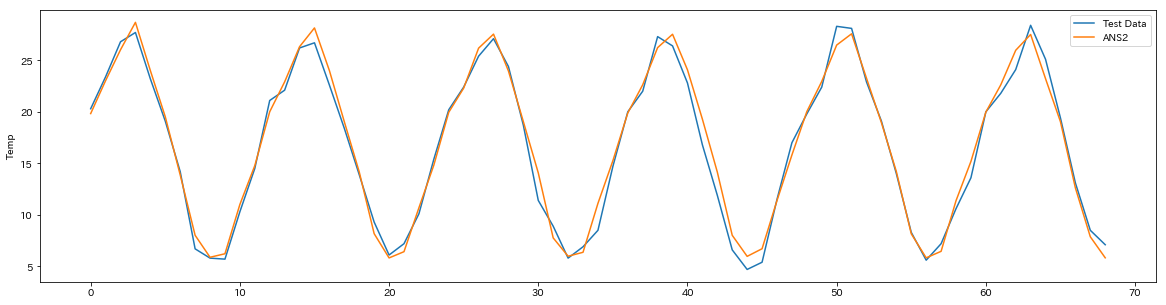

In [280]:
plt.plot(y_test, label='Test Data')
plt.plot(predict_ans2, label='ANS2')
plt.ylabel('Temp')
plt.legend()
plt.show()

# (3) 特徴量の追加

In [83]:
# train
data_train = []
for i in X_train:
    nm_max = np.max(i[0]) # 最大値
    nm_min = np.min(i[0]) # 最小値
    nm_ave = np.average(i[0]) # 重み付け平均も可能
    nm_med = np.median(i[0]) # 中央値
    nm_std = np.std(i[0]) # 標準偏差
    data_train.append(np.append(np.array(i[0]), [nm_max, nm_min, nm_ave, nm_med, nm_std]))
data_train = np.array(data_train)

In [84]:
data_test = []
for i in X_test:
    nm_max = np.max(i[0])
    nm_min = np.min(i[0])
    nm_ave = np.average(i[0]) # 重み付け平均も可能
    nm_med = np.median(i[0])
    nm_std = np.std(i[0])
    data_test.append(np.append(np.array(i[0]), [nm_max, nm_min, nm_ave, nm_med, nm_std]))
data_test = np.array(data_test)

In [85]:
X_train = np.reshape(data_train, (data_train.shape[0], 1, data_train.shape[1]))
X_test = np.reshape(data_test, (data_test.shape[0], 1, data_test.shape[1]))

In [86]:
print(X_train.shape, X_test.shape)

(120, 1, 57) (69, 1, 57)


In [90]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [91]:
# 学習epoch（0～）ごとに学習率低減を実装
def step_decay(epoch):
    x = 1e-3
    if epoch >= 150:
        x = 1e-4
    return x

In [92]:
model_decay = LearningRateScheduler(step_decay, verbose=1)

In [93]:
# 重みの保存を実装
model_check = ModelCheckpoint(filepath='weight_save3.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [96]:
model_ans3 = models.Sequential()
model_ans3.add(layers.GRU(80, # 情報量を増やしたので少し増やす
                               activation='tanh',
                               input_shape=(1, ts_size + 5) # 追加した大きさを忘れずに X_train.shape[2]も可
                              )
             )
model_ans3.add(layers.Dense(1))
model_ans3.add(layers.Activation("linear"))
model_ans3.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[metrics.mae])

In [97]:
print("# start ANS3")
his_ans3 = model_ans3.fit(
    X_train, y_train,
    batch_size=1, epochs=200, verbose=1, shuffle=False,
    validation_data=(X_test, y_test),
    callbacks=[model_decay, model_check]
)

# start ANS3
Train on 120 samples, validate on 69 samples
Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 1s 10ms/step - loss: 91.4884 - mean_absolute_error: 7.2841 - val_loss: 42.2642 - val_mean_absolute_error: 4.9113

Epoch 00001: val_loss improved from inf to 42.26418, saving model to weight_save.hdf5
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 28.2436 - mean_absolute_error: 3.8586 - val_loss: 13.8654 - val_mean_absolute_error: 2.6896

Epoch 00002: val_loss improved from 42.26418 to 13.86539, saving model to weight_save.hdf5
Epoch 3/200

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 10.5380 - mean_absolute_error: 2.4123 - val_loss: 5.0805 - val_mean_absolute_error: 1.6479

Epoch 00003: val_loss improved from 13.86539 to 5.08048, 

120/120 [==============================] - 0s 4ms/step - loss: 1.6603 - mean_absolute_error: 1.0316 - val_loss: 1.5264 - val_mean_absolute_error: 0.9964

Epoch 00028: val_loss did not improve from 1.09149
Epoch 29/200

Epoch 00029: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.8879 - mean_absolute_error: 1.0916 - val_loss: 1.6244 - val_mean_absolute_error: 1.0162

Epoch 00029: val_loss did not improve from 1.09149
Epoch 30/200

Epoch 00030: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.7443 - mean_absolute_error: 1.0453 - val_loss: 1.6758 - val_mean_absolute_error: 1.0091

Epoch 00030: val_loss did not improve from 1.09149
Epoch 31/200

Epoch 00031: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.7853 - mean_absolute_error: 1.0593 - val_loss: 1.6543 - val_mean_absolute_err


Epoch 00056: val_loss did not improve from 1.04100
Epoch 57/200

Epoch 00057: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.7129 - mean_absolute_error: 1.0263 - val_loss: 1.1771 - val_mean_absolute_error: 0.8760

Epoch 00057: val_loss did not improve from 1.04100
Epoch 58/200

Epoch 00058: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.6182 - mean_absolute_error: 0.9953 - val_loss: 1.7079 - val_mean_absolute_error: 1.0514

Epoch 00058: val_loss did not improve from 1.04100
Epoch 59/200

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.8806 - mean_absolute_error: 1.0970 - val_loss: 1.8424 - val_mean_absolute_error: 1.0640

Epoch 00059: val_loss did not improve from 1.04100
Epoch 60/200

Epoch 00060: LearningRateScheduler setting learning rate to 0.001.
120/120 [

120/120 [==============================] - 0s 4ms/step - loss: 1.3710 - mean_absolute_error: 0.9070 - val_loss: 1.2837 - val_mean_absolute_error: 0.8634

Epoch 00085: val_loss did not improve from 0.97741
Epoch 86/200

Epoch 00086: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.3552 - mean_absolute_error: 0.9347 - val_loss: 1.4419 - val_mean_absolute_error: 0.9368

Epoch 00086: val_loss did not improve from 0.97741
Epoch 87/200

Epoch 00087: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.5509 - mean_absolute_error: 0.9884 - val_loss: 1.3370 - val_mean_absolute_error: 0.8865

Epoch 00087: val_loss did not improve from 0.97741
Epoch 88/200

Epoch 00088: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.4773 - mean_absolute_error: 0.9906 - val_loss: 1.1859 - val_mean_absolute_err

120/120 [==============================] - 0s 4ms/step - loss: 1.6693 - mean_absolute_error: 0.9877 - val_loss: 1.3202 - val_mean_absolute_error: 0.8850

Epoch 00114: val_loss did not improve from 0.97741
Epoch 115/200

Epoch 00115: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.8562 - mean_absolute_error: 1.0881 - val_loss: 1.3685 - val_mean_absolute_error: 0.9370

Epoch 00115: val_loss did not improve from 0.97741
Epoch 116/200

Epoch 00116: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.5835 - mean_absolute_error: 0.9813 - val_loss: 1.4765 - val_mean_absolute_error: 0.9576

Epoch 00116: val_loss did not improve from 0.97741
Epoch 117/200

Epoch 00117: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.7299 - mean_absolute_error: 0.9962 - val_loss: 1.5788 - val_mean_absolute_

120/120 [==============================] - 0s 4ms/step - loss: 1.3210 - mean_absolute_error: 0.8997 - val_loss: 1.3881 - val_mean_absolute_error: 0.9533

Epoch 00143: val_loss did not improve from 0.97741
Epoch 144/200

Epoch 00144: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.3245 - mean_absolute_error: 0.8905 - val_loss: 1.4515 - val_mean_absolute_error: 0.9540

Epoch 00144: val_loss did not improve from 0.97741
Epoch 145/200

Epoch 00145: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.3631 - mean_absolute_error: 0.8852 - val_loss: 1.6015 - val_mean_absolute_error: 1.0101

Epoch 00145: val_loss did not improve from 0.97741
Epoch 146/200

Epoch 00146: LearningRateScheduler setting learning rate to 0.001.
120/120 [==============================] - 0s 4ms/step - loss: 1.3837 - mean_absolute_error: 0.8926 - val_loss: 1.5906 - val_mean_absolute_


Epoch 00171: val_loss did not improve from 0.97741
Epoch 172/200

Epoch 00172: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 0s 4ms/step - loss: 0.8119 - mean_absolute_error: 0.6836 - val_loss: 1.3246 - val_mean_absolute_error: 0.9421

Epoch 00172: val_loss did not improve from 0.97741
Epoch 173/200

Epoch 00173: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 0s 4ms/step - loss: 0.8122 - mean_absolute_error: 0.6830 - val_loss: 1.3253 - val_mean_absolute_error: 0.9423

Epoch 00173: val_loss did not improve from 0.97741
Epoch 174/200

Epoch 00174: LearningRateScheduler setting learning rate to 0.0001.
120/120 [==============================] - 0s 4ms/step - loss: 0.8125 - mean_absolute_error: 0.6823 - val_loss: 1.3264 - val_mean_absolute_error: 0.9426

Epoch 00174: val_loss did not improve from 0.97741
Epoch 175/200

Epoch 00175: LearningRateScheduler setting learning rate to 0.0001.
1

120/120 [==============================] - 0s 4ms/step - loss: 0.7764 - mean_absolute_error: 0.6671 - val_loss: 1.4273 - val_mean_absolute_error: 0.9657

Epoch 00200: val_loss did not improve from 0.97741


In [98]:
model_ans3.load_weights("weight_save3.hdf5")

In [99]:
predict_ans3 = model_ans3.predict(X_test)
print("ANS3 RMSE：", mean_squared_error(y_test, predict_ans3))

ANS3 RMSE： 0.9774130428371108


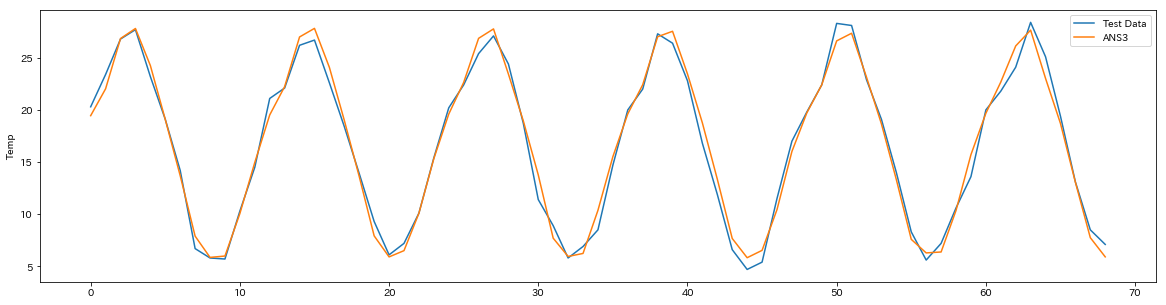

In [100]:
plt.plot(y_test, label='Test Data')
plt.plot(predict_ans3, label='ANS3')
plt.ylabel('Temp')
plt.legend()
plt.show()

# (4)パラメータチューニング